### Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### standard values

In [2]:
gate_ctt = np.array([165, 315, 465, 615, 765, 915, 1065, 1215, 1365, 1515], dtype = int)

In [3]:
g_en5 = -7.711545013271975

In [4]:
nseeds = 10

In [5]:
dep = np.arange(1, 11, 1, dtype = int)

In [6]:
base_expo = [[1,6], [5,6], [1,5], [5,5], [1,4], [5,4], [1,3]]

In [7]:
eps = [b[0]*(10**(-b[1])) for b in base_expo]

In [8]:
perr = []
exp_off = []
for yt in range(len(eps)):
    p_er = np.array(1 - (1-eps[yt])**gate_ctt)
    perr.append(perr)
    exp_off.append(1 - p_er)

### noiseless data

In [9]:
with open('Results/noiseless_COBY_rand_runs.pkl', 'rb') as file:
    yruns = pickle.load(file)

In [10]:
with open('Results/noiseless_COBY_rand_list.pkl', 'rb') as file:
    ylist = pickle.load(file)

In [11]:
res_data_idm = []
res_data_ids = []
val_list_idm = []
val_list_ids = []

In [12]:
for gt in dep:
    yran = np.array(yruns['%s'%gt])
    ylis = np.array(ylist['%s'%gt])
    # Compute mean and standard deviation across runs
    mean_y = np.mean(yran, axis=0)
    std_y = np.std(yran, axis=0)
    val = np.mean(ylis, axis=0)
    val_std = np.std(ylis, axis=0)
    res_data_idm.append(mean_y)
    res_data_ids.append(std_y)
    val_list_idm.append(val)
    val_list_ids.append(val_std)

### noisy data

In [13]:
noisy_data_mean = {}
noisy_data_std = {}
noisy_data_val_m = {}
noisy_data_val_s = {}
for gt in range(len(base_expo)):
    #with open('global_noisy_seeds_gates/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
    with open('Results/global_noisy_gates_seeds_assumptions_COBY_scipy/noisy-%s_%s.pkl'%(base_expo[gt][0], base_expo[gt][1]), 'rb') as file:
        res = pickle.load(file)
    res_data_mean = []
    res_data_std = []
    val_list = []
    val_std = []
    for pt in dep:
        yran = []
        ylis = []
        for ht in np.arange(0, nseeds, 1, dtype = int):
            re = eval(res['%s'%ht][pt-1].meta_data['optimization_trace'])
            vv = res['%s'%ht][pt-1].value
            app = [vv for yt in range(25000-len(re))]
            yran.append(re + app)
            ylis.append(vv)
        yseed_opt = np.array(yran)
        yseed_val = np.array(ylis)
        mean_y = np.mean(yseed_opt, axis=0)
        std_y = np.std(yseed_opt, axis=0)
        val = np.mean(yseed_val, axis=0)
        val_sig = np.std(yseed_val, axis=0)
        res_data_mean.append(mean_y)
        res_data_std.append(std_y)
        val_list.append(val)
        val_std.append(val_sig)
    noisy_data_mean['%s'%gt] = res_data_mean
    noisy_data_std['%s'%gt] = res_data_std
    noisy_data_val_m['%s'%gt] = val_list
    noisy_data_val_s['%s'%gt] = val_std

### selected noiseless data plot

In [14]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [15]:
plt.rcParams.update({'font.size': 16})

#### exponential decay in noiseless for plot only

/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


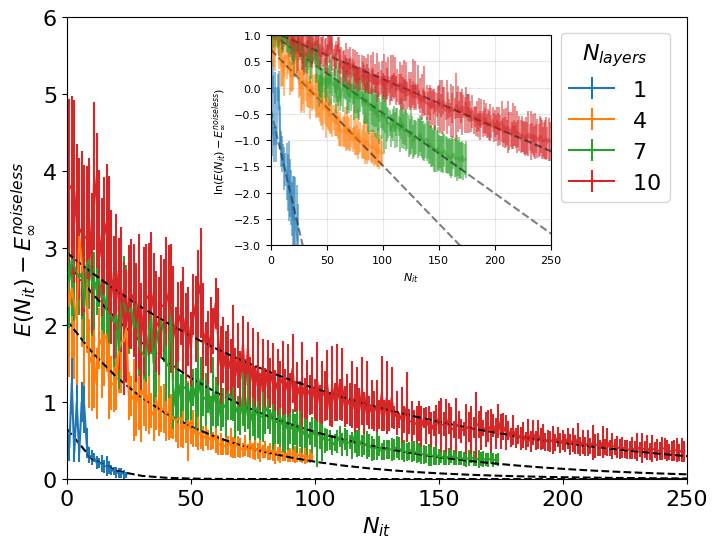

In [16]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.38, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype=int)
fit_ran = 25

for gt in range(0, len(res_data_idm), 3):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)

    # Plot in main axes
    ax.errorbar(xp, yp, yerr=std_devs, fmt='-', label=r'$%s$' %(gt+1))
    
    # Plot fitted exponential model in main axes
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    ax.plot(x_fit, y_fit, '--k')
    
    # Plot in inset (log-linear)
    inset_ax.errorbar(xp, np.log(yp), yerr=std_devs/yp, fmt='-', alpha=0.5)
    inset_ax.plot(x_fit, np.log(y_fit), '--k', alpha=0.5)

# Main axes settings
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 6)
ax.legend(bbox_to_anchor=(0.99, 0.99), title=r'$N_{layers}$')

# Inset axes settings
inset_ax.set_xlim(0, 250)
inset_ax.set_ylim(-3, 1)
inset_ax.set_xlabel(r'$N_{it}$', fontsize=8)
inset_ax.set_ylabel(r'$\ln(E(N_{it}) - E_{\infty}^{noiseless})$', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.grid(True, alpha=0.3)
#plt.savefig('figs/noiseless_E_t_inset.pdf', bbox_inches='tight')
plt.show()

#### for all depths for complete analysis

/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


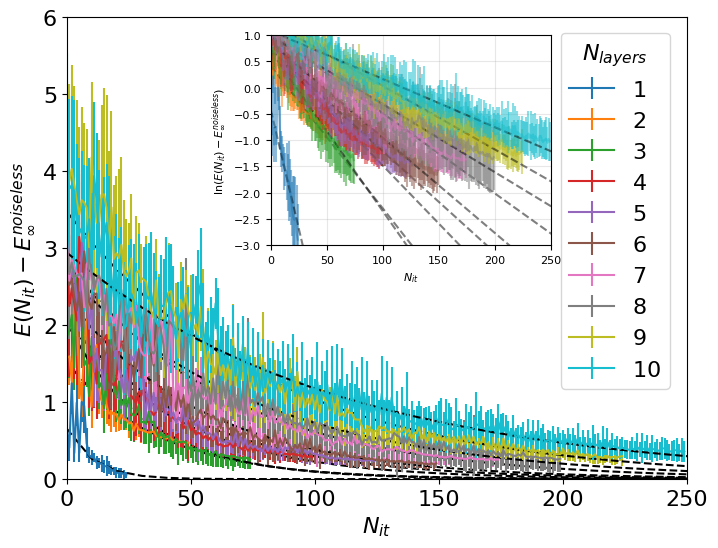

In [17]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.38, 0.5, 0.35, 0.35])  # [left, bottom, width, height]

gam = []
gam_err = []
xx = np.arange(0, 25000, 1, dtype=int)
fit_ran = 25

for gt in range(0, len(res_data_idm), 1):
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_idm[gt])-val_list_idm[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_ids[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    gam_err.append(b_err)
    gam.append(b)

    # Plot in main axes
    ax.errorbar(xp, yp, yerr=std_devs, fmt='-', label=r'$%s$' %(gt+1))
    
    # Plot fitted exponential model in main axes
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    ax.plot(x_fit, y_fit, '--k')
    
    # Plot in inset (log-linear)
    inset_ax.errorbar(xp, np.log(yp), yerr=std_devs/yp, fmt='-', alpha=0.5)
    inset_ax.plot(x_fit, np.log(y_fit), '--k', alpha=0.5)

# Main axes settings
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noiseless}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 6)
ax.legend(bbox_to_anchor=(0.99, 0.99), title=r'$N_{layers}$')

# Inset axes settings
inset_ax.set_xlim(0, 250)
inset_ax.set_ylim(-3, 1)
inset_ax.set_xlabel(r'$N_{it}$', fontsize=8)
inset_ax.set_ylabel(r'$\ln(E(N_{it}) - E_{\infty}^{noiseless})$', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.grid(True, alpha=0.3)
#plt.savefig('figs/noiseless_E_t_inset.pdf', bbox_inches='tight')
plt.show()

### fitting convergence rate

In [70]:
n_lay = 10

In [71]:
# Define power law
def noiseless_power_model(x, a, b):
    return a * ((x-100)**-b)

/tmp/ipykernel_92007/199349251.py:3: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**-b)


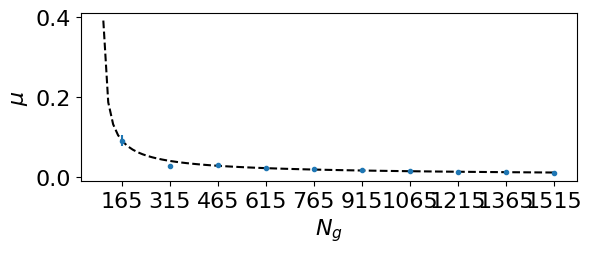

In [72]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.errorbar(gate_ctt[0:n_lay], gam[0:n_lay], yerr=gam_err[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(noiseless_power_model, gate_ctt[0:n_lay], gam[0:n_lay], sigma=gam_err[0:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = noiseless_power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = noiseless_power_model(gate_ctt[0:n_lay], a, b)

residuals = np.array(gam[0:n_lay]) - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(gam_err[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum(( np.array(gam[0:n_lay])-np.mean( np.array(gam[0:n_lay])))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$ \mu$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim([100,2000])
#ax.set_ylim([0.005,0.5])
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.show()

In [73]:
print(a, a_err, b, b_err)

1.6652961475559356 0.2782930445114287 0.6945170386256264 0.02433834055155108


In [74]:
print(r_sq, chi_sq)

0.9636009055645968 0.36854870045077526


### selected noisy data plot

In [75]:
sel = 2

In [76]:
base_expo[sel]

[1, 5]

In [77]:
res_data_mean = noisy_data_mean['%s'%sel]
res_data_std = noisy_data_std['%s'%sel]
val_list = noisy_data_val_m['%s'%sel]

In [78]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/home/harshit-verma/Desktop/eviden/eviden/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:538: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


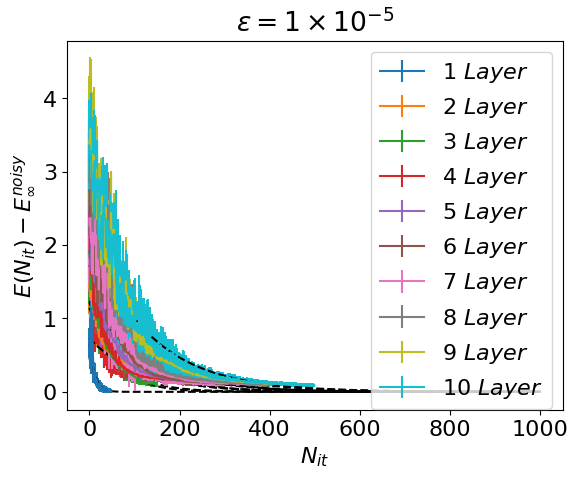

In [79]:
#fitting using the mean data with error propagation
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
alp = []
alp_err = []
E00 = []
E00_err = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 50
for gt in range(0, len(res_data_mean), 1): 
#for gt in [3]:
    fit_range = (gt+1)*fit_ran
    yy = np.array(res_data_mean[gt])-val_list[gt]
    xp = xx[0:fit_range]
    yp = yy[0:fit_range]
    std_devs = res_data_std[gt][0:fit_range]

    # Fit model with weights
    params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
    a, b = params
    a_err, b_err = np.sqrt(np.diag(cv))
    alp_err.append(b_err)
    alp.append(b)
    E00.append(a)
    E00_err.append(a_err)
    #y_fit = exp_model(xp, a, b)

    plt.errorbar(xp, yp, yerr=std_devs, fmt='-', label = r'$%s~Layer$' %(gt+1))

    # Plot fitted exponential model
    x_fit = np.linspace(0, 1000, 100)
    y_fit = exp_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit, '--k', label= r'$F~%s~Layer$' %(gt+1))
    plt.plot(x_fit, y_fit, '--k')

plt.title(r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
#ax.set_yscale('log')
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ E(N_{it}) - E_{\infty}^{noisy}$')
#plt.axis([0, 250, 0, 4])
#ax.legend(ncol = 2, bbox_to_anchor = (1, 0.1))
ax.legend()
#plt.savefig('noisy_alpha.pdf', bbox_inches = 'tight')
plt.show()

In [80]:
E00

[0.6447213393168837,
 1.1452044199317326,
 1.486247192310029,
 0.730900266537831,
 1.2084165815322727,
 1.468475315032409,
 1.2329889425058345,
 1.400278759141653,
 1.7264591783211611,
 2.157135443545092]

In [81]:
E00_err

[0.08734029260940337,
 0.06989557242286144,
 0.07554664543495075,
 0.0461306138510827,
 0.0511550801018726,
 0.07627762907352106,
 0.06977469572115237,
 0.052683511295271206,
 0.05125593760802161,
 0.06078897727521751]

In [82]:
alp

[0.08738135515472593,
 0.015851768393363105,
 0.019723242560146993,
 0.008979304464456377,
 0.010784466445452655,
 0.011020964031595918,
 0.008392466917892147,
 0.00845017333785455,
 0.0074896197006432295,
 0.007640258845253884]

In [83]:
alp_err

[0.00905728502646627,
 0.0016062954787321524,
 0.0006608753839081685,
 0.00045401543908478166,
 0.0003109977819864964,
 0.00033198261191578484,
 0.0002560623922741034,
 0.00018095241462936427,
 0.00011813107640416977,
 0.00010358790645274083]

### fitting noisy $\alpha$ for all $\epsilon$

In [84]:
n_lay = 10

In [85]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(-b * x)

In [86]:
alp_list = []
alp_err_list = []
xx = np.arange(0, 25000, 1, dtype = int)
fit_ran = 25
for gt in range(len(base_expo)):
    res_data_mean = noisy_data_mean['%s'%gt]
    res_data_std = noisy_data_std['%s'%gt]
    val_list = noisy_data_val_m['%s'%gt]
    #fitting using the mean data with error propagation
    alp = []
    alp_err = []
    for gt in range(0, len(res_data_mean), 1):
        fit_range = (gt+1)*fit_ran
        yy = np.array(res_data_mean[gt])-val_list[gt]
        xp = xx[0:fit_range]
        yp = yy[0:fit_range]
        std_devs = res_data_std[gt][0:fit_range]
        # Fit model with weights
        params, cv = curve_fit(exp_model, xp, yp, sigma=std_devs, absolute_sigma=True)
        a, b = params
        a_err, b_err = np.sqrt(np.diag(cv))
        alp_err.append(b_err)
        alp.append(b)
    alp_list.append(alp)
    alp_err_list.append(alp_err)

/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/tmp/ipykernel_92007/2599236198.py:3: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


In [87]:
# Define fit model
def noisy_power_model(x, a, b):
    #return a * np.exp(-b * x)
    return a * ((x-100)**b)

In [88]:
import itertools
marker = itertools.cycle(('o', 'v', 's', 'd', '*', '^', 'x', 'p')) 

### Plotting $\nu$

/tmp/ipykernel_92007/3992067186.py:4: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**b)


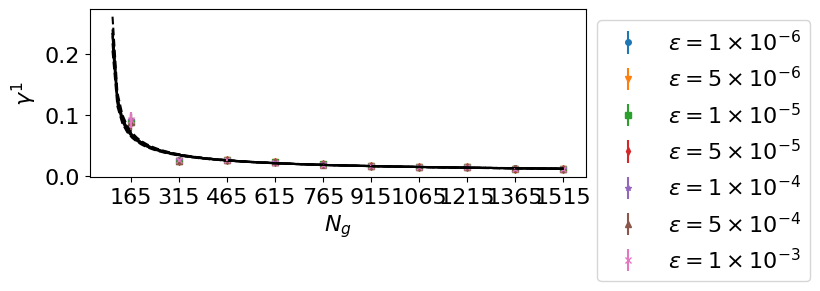

In [89]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []
for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[0:n_lay], alp_list[gt][0:n_lay], yerr=alp_err_list[gt][0:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(noisy_power_model, gate_ctt[0:n_lay], alp_list[gt][0:n_lay], sigma=alp_err_list[gt][0:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
    y_fit = noisy_power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    y_fitt = noisy_power_model(gate_ctt[0:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][0:n_lay]) - y_fitt
    chi_sq = np.sum(np.divide(residuals, np.array(alp_err_list[gt][0:n_lay])))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(( np.array(alp_list[gt][0:n_lay])-np.mean(np.array(alp_list[gt][0:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
plt.legend(bbox_to_anchor = (1, 1))
ax.set_ylabel(r'$ \gamma^1$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim([50,1000])
#ax.set_ylim([0.005,0.5])
#plt.savefig('noisy_alpha_fit.pdf', bbox_inches = 'tight')
plt.show()

In [90]:
alp_fit

[0.7895608697796079,
 0.7113832947650026,
 0.9306289244654383,
 0.7662311551573118,
 0.7914031367120784,
 0.6525612727540777,
 0.8216775772599118]

In [91]:
alp_err_fit

[0.14983609071560622,
 0.13881736408866877,
 0.1764246634090873,
 0.1458534665386106,
 0.15086136233623418,
 0.12662895048132328,
 0.15763191049743358]

In [92]:
bet_fit

[-0.5826551050336969,
 -0.5689100146836651,
 -0.6099498222092562,
 -0.5800427764271935,
 -0.583670950074214,
 -0.5549556764217708,
 -0.5899294409190399]

In [93]:
bet_err_fit

[0.027437345874868693,
 0.02820220842636993,
 0.027305124471088373,
 0.027436130400788895,
 0.02750574344508814,
 0.028006701810394274,
 0.027668712714600398]

In [94]:
rsq

[0.9021766800747514,
 0.8741124960225144,
 0.9258422482373732,
 0.8896647113718223,
 0.8868450409685356,
 0.857672051641373,
 0.8958510806808848]

In [95]:
csq

[-0.5107647731368892,
 0.40591178187330734,
 -0.01451536864286096,
 0.14375639345474234,
 0.03868183646925738,
 0.4870547352683341,
 -0.07767889630402935]

In [96]:
np.mean(alp_fit)

0.7804923186990613

In [97]:
np.mean(alp_err_fit)

0.14943625829528057

In [98]:
np.mean(bet_fit)

-0.5814448265384051

In [99]:
np.mean(bet_err_fit)

0.02765170959188553

In [100]:
strt = 0

### Plotting $\nu$ and $\mu$

/tmp/ipykernel_92007/199349251.py:3: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**-b)
/tmp/ipykernel_92007/3992067186.py:4: RuntimeWarning: invalid value encountered in power
  return a * ((x-100)**b)


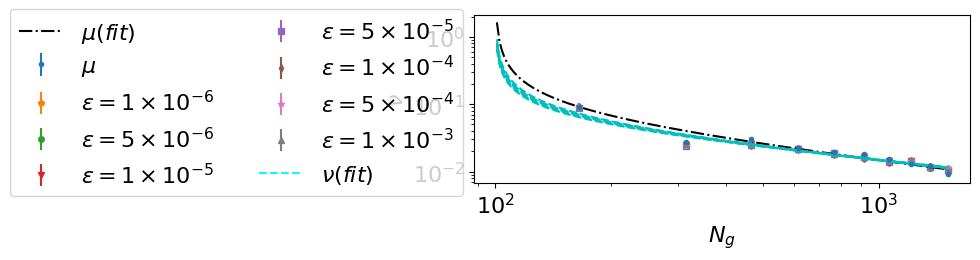

In [102]:
import matplotlib.lines as mlines

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
resi = []
rsq = []
csq = []
alp_err_fit = []
alp_fit = []
bet_err_fit = []
bet_fit = []

#firs noiseless gamma
plt.errorbar(gate_ctt[strt:n_lay], gam[strt:n_lay], yerr=gam_err[strt:n_lay], fmt='.',  label = r'$\mu$')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
pm, cv = curve_fit(noiseless_power_model, gate_ctt[strt:n_lay], gam[strt:n_lay], sigma=gam_err[strt:n_lay], absolute_sigma=True)
a, b = pm
a_err, b_err = np.sqrt(np.diag(cv))
#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 1000)
y_fit = noiseless_power_model(x_fit, a, b)
#plt.plot(x_fit, y_fit)

y_fitt = noiseless_power_model(gate_ctt[strt:n_lay], a, b)

# Plot regression line
ax.plot(x_fit, y_fit, '-.k', lw=1.5, label = r'$\mu (fit)$');

resi_0 = np.array(gam[strt:n_lay]) - y_fitt
chi_sq_0 = np.sum(np.divide(resi_0, np.array(gam_err[strt:n_lay])))
ss_res_0 = np.sum(resi_0**2)
ss_tot_0 = np.sum(( np.array(gam[strt:n_lay])-np.mean( np.array(gam[strt:n_lay])))**2)
r_sq_0 = 1 - (ss_res_0 / ss_tot_0)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

#now noisy alpha

for gt in range(len(alp_list)):
    plt.errorbar(gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], yerr=alp_err_list[gt][strt:n_lay], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[gt][0], base_expo[gt][1]))
    #pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)
        
    #Fit model with weights
    pm, cv = curve_fit(noisy_power_model, gate_ctt[strt:n_lay], alp_list[gt][strt:n_lay], sigma=alp_err_list[gt][strt:n_lay], absolute_sigma=True)
    a, b = pm
    a_err, b_err = np.sqrt(np.diag(cv))
    #Plot fitted exponential model
    x_fit = np.linspace(1, gate_ctt[n_lay-1], 1000)
    y_fit = noisy_power_model(x_fit, a, b)
    #plt.plot(x_fit, y_fit)
    
    y_fitt = noisy_power_model(gate_ctt[strt:n_lay], a, b)
    
    residuals = np.array(alp_list[gt][strt:n_lay]) - y_fitt
    chi_sq = np.sum(np.divide(residuals, np.array(alp_err_list[gt][strt:n_lay])))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((np.array(alp_list[gt][strt:n_lay])-np.mean(np.array(alp_list[gt][strt:n_lay])))**2)
    r_sq = 1 - (ss_res / ss_tot)

    resi.append(residuals)
    rsq.append(r_sq)
    csq.append(chi_sq)

    alp_err_fit.append(a_err)
    bet_err_fit.append(b_err)
    alp_fit.append(a)
    bet_fit.append(b)
    
    # Create sequence of 100 numbers from 0 to 100 
    #xn = np.linspace(1, gate_ct[n_lay-1], num=50)
    
    # Plot regression line
    ax.plot(x_fit, y_fit, '--c', lw=1.5)

# Add an extra line in the legend
l4 = mlines.Line2D([], [], color="cyan", linestyle="--", label = r"$\nu(fit)$")

# Get existing handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Add the extra line to the handles
handles.append(l4)

# Create the legend with all lines
plt.legend(handles=handles, ncol = 2, bbox_to_anchor = (0, 1.1))

ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
    
#plt.savefig('noiseless_gamma_fit.pdf', bbox_inches = 'tight')
#plt.legend(bbox_to_anchor = (0.1, 1.1), ncol =3)
ax.set_ylabel(r'$ \nu$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([50, 1000])
#ax.set_ylim([0.005, 0.5])
#plt.savefig('COBYLA_plots/noisy_alpha_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

### difference in E(t) noisy and noiseless

In [103]:
xx = np.arange(1, 25001, 1, dtype =int)

In [105]:
sel = 6

-0.0004795965890973415
0.024846098438900635
0.005172210319002329
0.009448915244282692
-0.0035788361132127167
-0.007229551783479048
0.005769179298043723
-0.0035371055133340446
0.0066454182997232
0.014697744010709292


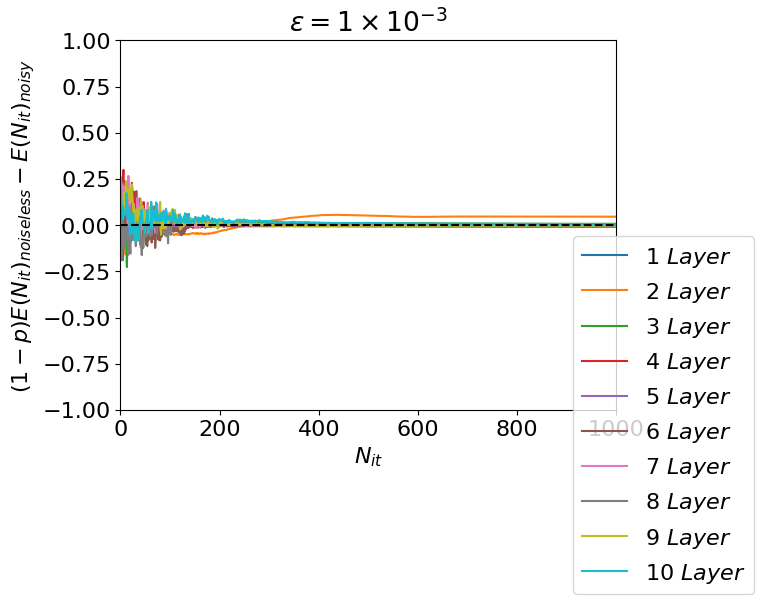

In [106]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for gt in dep:
    diff = np.multiply(exp_off[sel][gt-1], np.array(res_data_idm[gt-1]))- np.array(noisy_data_mean['%s'%sel][gt-1])
    #print(np.multiply(exp_off[sel][gt-1], res_data_idm[gt-1][-1]) - np.min(res_data_mean[gt-1]))
    #diff = np.multiply(exp_off[sel][gt-1]*np.ones(len(res_data_idm[gt-1])), np.array(res_data_idm[gt-1]))- np.array(res_data_mean[gt-1])
    print(np.mean(diff[0:1000]))
    ax.plot(xx, diff, label = r'$%s~Layer$' %(gt))
ax.set_xlabel(r'$N_{it}$')
ax.set_ylabel(r'$ (1-p)E(N_{it})_{noiseless}- E(N_{it})_{noisy}$')
ax.legend(ncol = 1, bbox_to_anchor = (1.3, 0.5))
plt.axis([0, 1000, -1, 1])
#ax.set_yscale('log')
plt.title( r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[sel][0], base_expo[sel][1]))
plt.axhline(0, color = 'k', xmin = 0, xmax = 25000, linestyle = '--')
#plt.savefig('opt_trace_diff.pdf', bbox_inches = 'tight')
plt.show()

### difference in $E_\infty$ noisy and noiseless

/tmp/ipykernel_92007/2050509980.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


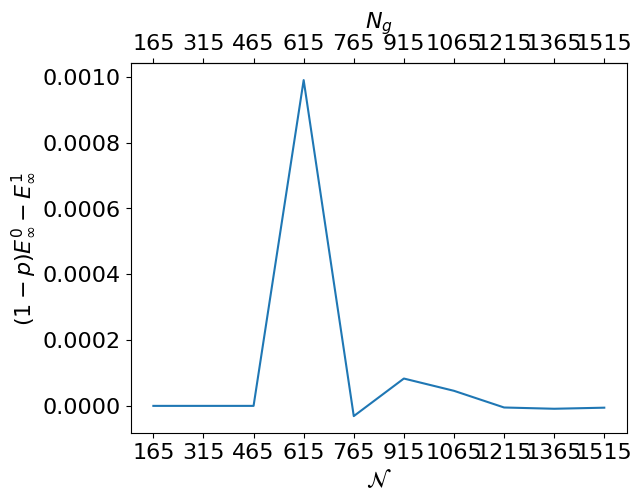

In [107]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
diff = np.multiply(np.array(exp_off[sel]), np.array(val_list_idm)) - np.array(noisy_data_val_m['%s'%sel])
ax.plot(gate_ctt, diff)
ax.set_xlabel('$\mathcal{N}$')
ax.set_ylabel(r'$ (1-p)E_{\infty}^0 - E_{\infty}^1$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
#ax.legend(ncol = 2, bbox_to_anchor = (1.5, 0.25))
#plt.axis([0, 5000, -0.5, 0.5])
#ax.set_yscale('log')
plt.show()

### $E_\infty$ as a function of $\mathcal{N}$

In [108]:
import itertools
marker = itertools.cycle(('o-', 'v-', 's-', 'd-', '*-', '^-', 'x-', 'p-')) 

/tmp/ipykernel_92007/4216337875.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_xticklabels(gate_ctt)


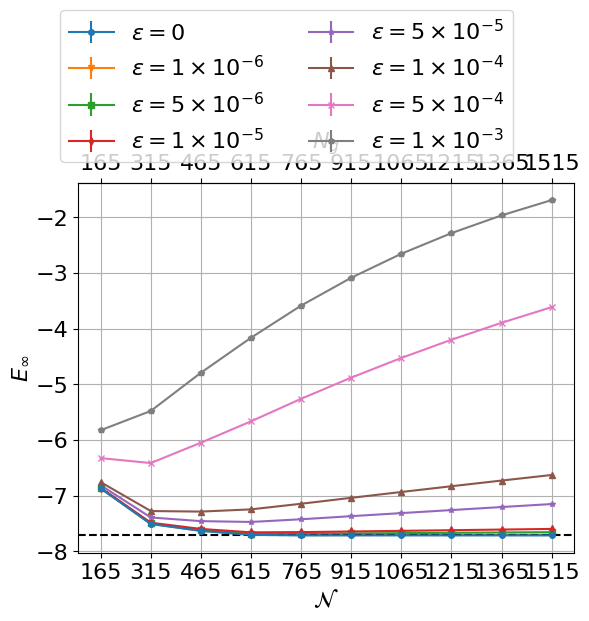

In [109]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.plot(gate_ct, val_list_id, label = r'$\epsilon = 0$')
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt = next(marker), markersize=4, label = r'$\epsilon = 0$')
for rt in range(len(base_expo)):
    #ax.plot(gate_ct, np.array(noisy_data_val['%s'%rt]), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
    #ax.plot(gate_ct, np.multiply(exp_off[rt], val_list_id), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    #diff =  np.multiply(exp_off[rt], val_list_id) - np.array(noisy_data_val['%s'%rt])
    #ax.plot(gate_ct, diff, label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_xlabel(r'$\mathcal{N}$')
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
axx = ax.secondary_xaxis('top')
axx.set_xticklabels(gate_ctt)
axx.set_xlabel(r'$N_g$')
axx.set_xticks(gate_ctt)
axx.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
plt.legend(ncol = 2, bbox_to_anchor = (0.9, 1.5))
#ax.set_yscale('log')
plt.grid()
#plt.savefig('noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

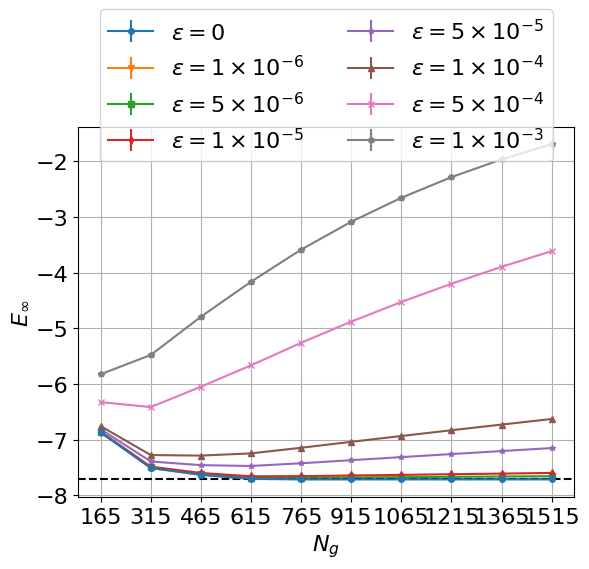

In [110]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.plot(gate_ct, val_list_id, label = r'$\epsilon = 0$')
plt.errorbar(gate_ctt, val_list_idm, yerr = val_list_ids, fmt = next(marker), markersize=4, label = r'$\epsilon = 0$')
for rt in range(len(base_expo)):
    #ax.plot(gate_ct, np.array(noisy_data_val['%s'%rt]), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    plt.errorbar(gate_ctt, np.array(noisy_data_val_m['%s'%rt]), yerr = noisy_data_val_s['%s'%rt], fmt = next(marker), markersize=4, barsabove = True, label = r'$\epsilon = %s \times 10^{-%s}$'%(base_expo[rt][0], base_expo[rt][1]))
    #ax.plot(gate_ct, np.multiply(exp_off[rt], val_list_id), label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
    #diff =  np.multiply(exp_off[rt], val_list_id) - np.array(noisy_data_val['%s'%rt])
    #ax.plot(gate_ct, diff, label = r'$\epsilon = %s \times 10^%s$'%(base_expo[rt][0], base_expo[rt][1]))
ax.set_ylabel(r'$ E_\infty$')
ax.set_xticks(gate_ctt)
ax.set_xlabel(r'$N_g$')
ax.set_xticklabels(gate_ctt)
plt.axhline(g_en5, color = 'k', xmin = 0, xmax = 500, linestyle = '--')
plt.legend(ncol = 2, loc = "upper center", bbox_to_anchor = (0.5, 1.35))
#ax.set_yscale('log')
plt.grid()
plt.savefig('noisy_noiseless_conv_COBY.pdf', bbox_inches = 'tight')
plt.show()

In [111]:
n_lay = 10

In [112]:
# Define exponential model
def exp_model(x, a, b):
    return a * np.exp(b * x)

In [113]:
# Define exponential model
def lin_model(x, a, b):
    return a * x + b

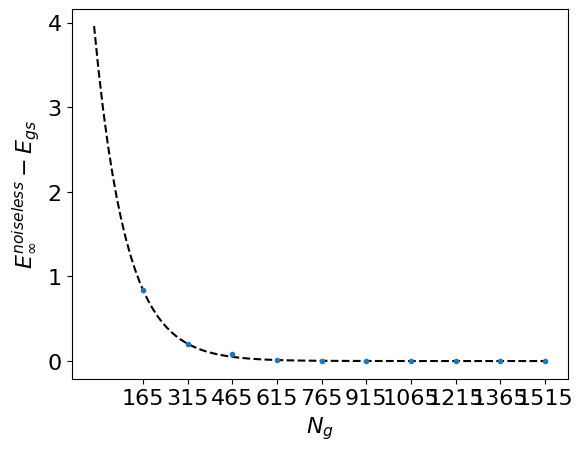

In [114]:
#fitting power law on noiseless gamma
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#plt.plot(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 'o')
plt.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, yerr = val_list_ids[0:n_lay], fmt='.')
#pfit, cv  = np.polyfit(gate_ct[0:n_lay], np.log(gam[0:n_lay]), w = 1/np.sqrt(gam_err[0:n_lay]), deg=1, cov = True)

#Fit model with weights
#pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5))
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], np.log(np.array(val_list_idm[0:n_lay]) - g_en5), sigma=np.divide(val_list_ids[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5), absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

#Plot fitted exponential model
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)

a_err = np.exp(b_er)
b_err = a_er

y_fitt = exp_model(gate_ctt[0:n_lay], np.exp(b), a)

residuals = np.array(val_list_idm[0:n_lay]) - g_en5 - y_fitt
chi_sq = np.sum(np.divide(residuals, np.array(val_list_ids[0:n_lay])))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.array(np.array(val_list_idm[0:n_lay]) - g_en5)-np.mean(np.array(val_list_idm[0:n_lay]) - g_en5))**2)
r_sq = 1 - (ss_res / ss_tot)

# Create sequence of 100 numbers from 0 to 100 
#xn = np.linspace(1, gate_ct[n_lay-1], num=50)

# Plot regression line
ax.plot(x_fit, y_fit, '--k', lw=1.5);
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim([50,900])
#ax.set_ylim([-0.1, 1])
#plt.savefig('COBYLA_plots/noiseless_conv_en_fit_COBY.pdf', bbox_inches = 'tight')
plt.show()

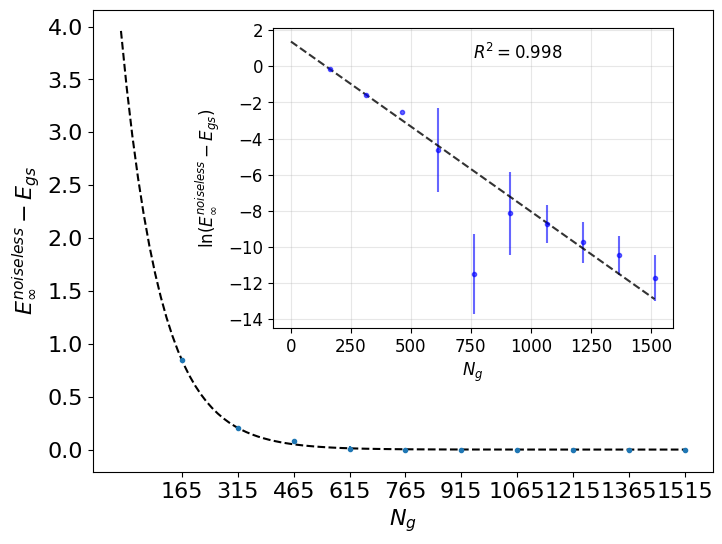

In [115]:
# Create main figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

# Create inset axes for log-linear plot
inset_ax = fig.add_axes([0.35, 0.35, 0.5, 0.5])  # [left, bottom, width, height]

# Main plot
ax.errorbar(gate_ctt[0:n_lay], np.array(val_list_idm[0:n_lay]) - g_en5, 
             yerr=val_list_ids[0:n_lay], fmt='.')

# Fit model with weights
pm, cv = curve_fit(lin_model, gate_ctt[0:n_lay], 
                  np.log(np.array(val_list_idm[0:n_lay]) - g_en5), 
                  sigma=np.divide(val_list_ids[0:n_lay], 
                                np.array(val_list_idm[0:n_lay]) - g_en5), 
                  absolute_sigma=True)
a, b = pm
a_er, b_er = np.sqrt(np.diag(cv))

# Plot fitted exponential model in main axes
x_fit = np.linspace(1, gate_ctt[n_lay-1], 100)
y_fit = exp_model(x_fit, np.exp(b), a)
ax.plot(x_fit, y_fit, '--k', lw=1.5)

# Inset: log-linear plot
y_data = np.array(val_list_idm[0:n_lay]) - g_en5
inset_ax.errorbar(gate_ctt[0:n_lay], np.log(y_data), 
                 yerr=np.divide(val_list_ids[0:n_lay], y_data), 
                 fmt='.', color='blue', alpha=0.6)
inset_ax.plot(x_fit, np.log(y_fit), '--k', lw=1.5, alpha=0.8)

# Main axes settings
ax.set_xlabel(r'$N_g$')
ax.set_xticks(gate_ctt)
ax.set_ylabel(r'$E_{\infty}^{noiseless} - E_{gs}$')
#ax.set_xlim([50,900])
#ax.set_ylim([-0.1, 1])

# Inset axes settings
inset_ax.set_xlabel(r'$N_g$', fontsize=12)
inset_ax.set_ylabel(r'$\ln(E_{\infty}^{noiseless} - E_{gs})$', fontsize=12)
inset_ax.tick_params(axis='both', which='major', labelsize=12)
inset_ax.grid(True, alpha=0.3)

# Add R² value to inset
r_squared_text = f'$R^2={r_sq:.3f}$'
inset_ax.text(0.5, 0.95, r_squared_text, transform=inset_ax.transAxes, 
              fontsize=12, verticalalignment='top')

#plt.savefig('noiseless_conv_en_fit_COBY_inset.pdf', bbox_inches = 'tight')

plt.show()

In [116]:
print(np.exp(b), a_err, a, b_err)

3.9963206737751635 1.0000000000051028 -0.009433079841830446 3.0188921252464634e-14


In [117]:
print(r_sq, chi_sq)

0.9984599875744752 3814165207.9153976


In [118]:
ss_res

0.0009688482517013246

In [119]:
a

-0.009433079841830446

In [120]:
b

1.3853741062590363

In [121]:
a_er

3.0188921252464634e-14

In [122]:
b_er

5.1028796554251646e-12